# Opteeq Compter Vision Project - Task B - Image Standardisation and Annotation Pipeline 

This notebook will detail the process of loading, standardisation and annotation of recipt images using the Google Cloud Vision API service. The processed images will then be saved back to S3 along with annotations and a JSON file containing relevant information ready for further manual annotation by the team. 

The code within this notebook will be tested for functionallity before being put into scripts and ran on an AWS EC2 instance. The structure of the notebook is as follows: 

                    1. Things to consider
                    2. Image read and write functions from S3 (boto3)
                    2. Image standardisation functions using the OpenCV library
                    3. Google Cloud Vision API call function
                    4. Main program testing 

# 1. Things to consider 

    - File naming convention (uuid? timestamp? Annotation files with matching uuid?)
    - Image format ? JPEG only?? 
    - JSON file structure (100 images per file?, tags? Image and annotation URIs?)
    - Build requirements.txt file 

# File naming conventions: 

Image = {uuid1}_{unix_timestamp}.jpeg

Annotations = {uuid1}_{unix_timestamp}.csv

JSON = standardised_annotated_imgs_{uuid(n)}_{unix_timestamp}_{team_member_name}.json

# S3 bucket file structure: 

    -bucket_name
        -data
            -unprocessed_data
                -raw_imgs
                    img1
                    img2
                    img3 
            -standardised_annotated_data  
                -img_annotations
                -standardised_imgs
                -json_files
                    -team_member_1
                    -team_member_2
                    -team_member_3 
            -fully_processed_data
                -processed_imgs
                -img_annotations
                -json_files
                

# JSON file structure: 

    -100 examples per file
    -1 team member per file

    json_structure = {
                {
                    "bucket": "bucket_name", 
                    "key": "data/standardised_annotated_data/standardised_imgs/{uuid1}_{unix_timestamp}.jpeg", 
                    "annotations": "data/standardised_annotated_data/img_annotations/{uuid1}_{unix_timestamp}.csv", 
                    "tags": "team_member1_name"
                },
                {
                    "bucket": "bucket_name", 
                    "key": "data/standardised_annotated_data/standardised_imgs/{uuid2}_{unix_timestamp}.jpeg", 
                    "annotations": "data/standardised_annotated_data/img_annotations/{uuid2}_{unix_timestamp}.csv", 
                    "tags": "team_member1_name"
                },
                {
                    "bucket": "bucket_name", 
                    "key": "data/standardised_annotated_data/standardised_imgs/{uuid3}_{unix_timestamp}.jpeg", 
                    "annotations": "data/standardised_annotated_data/img_annotations/{uuid3}_{unix_timestamp}.csv", 
                    "tags": "team_member1_name"
                }
           }

# 2. S3 read/write

We need to load all image files saved in a directory from an AWS S3 bucket. We can perform this task using the low level python sdk boto3 to interact with S3 from our EC2 instance. 

To begin we can use boto3 to access the location in the S3 bucket where the files are saved and find all of the image files in this location by reading only files with common image extensions compatible with OpenCV ('.JPEG', '.PNG', '.TIFF').  

Next we can loop through the image URIs and load each image using the OpenCV python module and store the images in an array ready for processing. Images can be loaded in as grayscale images to save memory.

When writing our information back to S3 we need to save the processed images with a specified file naming convention with a unique id, the csv files containing the annotations as well as JSON files containing the paths to the images the annotation csv file and a tag of the team member responsable for manually annotating the image. 

In [90]:
import boto3
import cv2
import uuid
import time

def get_image_paths_from_S3(bucket_name="bucket_name", key="data/unprocessed_data/raw_imgs"): 
    """Procedure: Using the boto
    -------
    Input
    -------
    bucket: String object containing S3 bucket name
    key: String object containing path to folder containing unprocessed images
    -------
    Output
    -------
    s3_image_paths: List object containing strings of paths to S3 locations where each image is located 
    """
    
    s3_client = boto3.client('s3')
    
    s3_img_paths = [] # List declaration to store image path locations
    
    try: # Try to read s3 bucket
        for obj in s3_client.list_objects_v2(Bucket=bucket_name, Prefix=key)['Contents']: # Loop through bucket directory contents
            if obj.endswith('.jpeg') or obj.endswith('.png') or obj.endswith('.tiff'):  # Check file extension
                s3_img_paths.append(obj) # If extension is ok append path to list
            else: 
                print("File not a compatible image file, must be of extension '.jpeg', '.png', '.tiff'.") # Else print warning
    except: # If try fails catch and print error message
        print("Error, could not retrieve image paths from s3 location: {}/{}".format(bucket_name, key)) 
    
    return s3_img_paths
    

def s3_image_read(key, bucket_name="bucket_name"):
    """Procedure:
    -------
    Input
    -------
    bucket: String object containing S3 bucket name
    key: String object containing S3 uri to an image
    -------
    Output
    -------
    img: Numpy array of image
    """
    try:
        img = bucket.Object(key).get().get('Body').read()
        nparray = cv2.imdecode(np.asarray(bytearray(img)), cv2.IMREAD_GRAYSCALE)
    except: 
        print("Error, image file could not be loaded.")
        
    return nparray

def db_write(bucket, key, processed_img): 
    """Procedure:
    -------
    Input:
    -------

    -------
    Output: 
    -------

    """
    timestamp = int(time.time())
    unique_id = uuid.uuid()
    
    
    # Creation of client for dynamodb
    dyndb_client = boto3.client('dynamodb', region_name=myRegion)


        response = dyndb_client.put_item(
            TableName = ,
            Item={

            }
            
        )
       

# 3. Image standardisation

During image standardisation we need to perform several operations to prepare images for annotation using the GCloud Vision API. This includes orienting the image correctly, ensuring that images have a minimum size and that the ratio of the images is suitable. 

Google Vision API reccommends 1067 x 768 image size for document text detection as OCR requires more resolution to detect characters.

Image resize code: 


Image angle detection code: 
https://stackoverflow.com/questions/58010660/detect-image-orientation-angle-based-on-text-direction/58020893

In [140]:
import cv2
import numpy as np

def image_resize(img, width = 768, height = 1067, inter = cv2.INTER_AREA):
    """Procedure: 
    -------
    Input:
    -------

    -------
    Output: 
    -------

    """
    # initialize the dimensions of the image to be resized and
    # grab the image size
    dim = None
    (h, w) = img.shape[:2]

    # if both the width and height are None, then return the
    # original image
    if width is None and height is None:
        return img

    # check to see if the width is None
    if width is None:
        # calculate the ratio of the height and construct the
        # dimensions
        r = height / float(h)
        dim = (int(w * r), height)

    # otherwise, the height is None
    else:
        # calculate the ratio of the width and construct the
        # dimensions
        r = width / float(w)
        dim = (width, int(h * r))

    # resize the image
    resized = cv2.resize(img, dim, interpolation = inter)

    # return the resized image
    return resized
    

def detect_angle(img):
    """Procedure:
    -------
    Input:
    -------

    -------
    Output: 
    -------

    """
    # Convert image to grayscale and perform a gaussian blur 
    # Then use adaptive threshhold to obtain a binary image
    mask = np.zeros(img.shape, dtype=np.uint8)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (3,3), 0)
    adaptive = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,15,4)
    
    
    # Find contours
    cnts = cv2.findContours(adaptive, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]

    # Filter using contour area to remove noise particles and large borders
    for c in cnts:
        area = cv2.contourArea(c)
        if area < 45000 and area > 20:
            cv2.drawContours(mask, [c], -1, (255,255,255), -1)
    
    # Pass contours that pass the filter onto a mask 
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    h, w = mask.shape
    
    # To determine the angle we split the image in half based the dimensions
    # If width > height then it must be a horizontal image so we split in half vertically
    # If height > width then it must be a vertical image so we split in half horizontally
 
    # Horizontal
    if w > h:
        left = mask[0:h, 0:0+w//2]
        right = mask[0:h, w//2:]
        left_pixels = cv2.countNonZero(left)
        right_pixels = cv2.countNonZero(right)
        return 0 if left_pixels >= right_pixels else 270 # Changed 180 to 270
    
    # Vertical
    else:
        top = mask[0:h//2, 0:w]
        bottom = mask[h//2:, 0:w]
        top_pixels = cv2.countNonZero(top)
        bottom_pixels = cv2.countNonZero(bottom)
        return 90 if bottom_pixels >= top_pixels else 180 # Changed 270 to 180
    
def rotate_image(img): 
    """Procedure: Get angle of text and rotate image to "90 degrees"
    -------
    Input:
    -------
    img: Numpy array of image 
    -------
    Output: 
    -------
    img: Rotated image
    """
    # Get image angle using angle detection function 
    img_angle = detect_angle(img)
    print(img_angle)
    
    # Rotate image to 90 degrees 
    if img_angle == 90:
        return img
    elif img_angle == 0: 
        return cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
    elif img_angle == 270:
        return cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
    elif img_angle == 180:
        return cv2.rotate(img, cv2.ROTATE_180)

# 3a. Testing image processing functions

# (i) Image resize

image shape: (450, 338, 3)


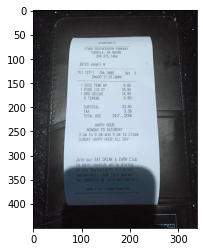

In [67]:
import cv2
import os
import matplotlib.pyplot as plt

#Local image load
img_path = os.path.abspath('data/1192-receipt.jpg') #Get absolute image path 
img = cv2.imread(img_path) # Read image from local directory for testing
#img = cv2.imread(img_path,cv2.IMREAD_GRAYSCALE) # Read grayscale image 

print("image shape: {}".format(img.shape)) # Return image dimensions

plt.imshow(img) # Display image using matplotlib

(1022, 768, 3)


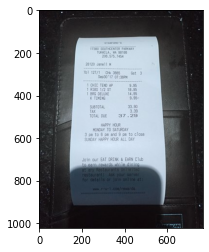

In [89]:
# Test image resize function
resized_img = image_resize(img, height = 1024, width = 768) # Set height to 1024 x 768
print(resized_img.shape)
plt.imshow(resized_img)

# (ii) Angle detection testing

In [68]:
# Rotate original image for angle detection rotation function testing
# Rotate image 90 degrees clockwise and write image
img_rotate_90_clockwise = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
cv2.imwrite(os.path.abspath('data') + '/1192_receipt_rotate_90_clockwise.jpg', img_rotate_90_clockwise)

# Rotate image 90 degrees counterclockwise and write image
img_rotate_90_counterclockwise = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
cv2.imwrite(os.path.abspath('data') + '/1192_receipt_rotate_90_counterclockwise.jpg', img_rotate_90_counterclockwise)

# Rotate image 180 degrees and write image
img_rotate_180 = cv2.rotate(img, cv2.ROTATE_180)
cv2.imwrite(os.path.abspath('data') + '/1192_receipt_rotate_180.jpg', img_rotate_180)

True

In [176]:
def angle_detection_test(img_paths):
    """Procedure: Loop through image filenames and call angle detection function
    -------
    Input:
    -------
    img_paths: List containing image filenames
    -------
    Output: 
    -------
    """
    # Loop through image filenames and contrust the absolute path for each image
    # Read image using OpenCV and run angle detection function, printing the filename and the angle of orientation
    for path in img_paths: 
        img = cv2.imread(os.path.abspath('data') + path)
        angle = detect_angle(img)
        print("{}: {} degrees".format(path, angle))

In [175]:
# Get image paths of same image with different orientations
img_paths = ['/1192-receipt.jpg', '/1192_receipt_rotate_90_counterclockwise.jpg', '/1192_receipt_rotate_90_clockwise.jpg', '/1192_receipt_rotate_180.jpg']

# Run angle detection function
angle_detection_test(img_paths)

/1192-receipt.jpg: 90 degrees
/1192_receipt_rotate_90_counterclockwise.jpg: 270 degrees
/1192_receipt_rotate_90_clockwise.jpg: 0 degrees
/1192_receipt_rotate_180.jpg: 180 degrees


# (iii) Image rotate function testing

In [172]:
def multi_img_plot(imgs): 
    """Procedure: Loop through list of images and plot each image on the same plot using matplotlib"
    -------
    Input:
    -------
    imgs: List of images
    -------
    Output: 
    -------
    Matplotlib figure containing subplots of each image
    """
    fig = plt.figure(figsize=(9, 13))
    
    columns = 4
    rows = 5
    
    for i in range(1,len(imgs)):
        fig.add_subplot(rows, columns, i)
        plt.imshow(imgs[i])
    plt.show()
    
def get_img_paths_local():
    """Procedure: Retrieve all files contained in the data directory construct absolute path. 
    Then, filter on filenames with .jpg extension"
    -------
    Input:
    -------
    None
    -------
    Output: 
    -------
    img_paths: List of absolute image paths 
    """
    img_paths = []
    
    paths = os.listdir(os.path.abspath('data'))
    
    for i, path in enumerate(paths):
        if path.endswith('.jpg'):
            img_paths.append(path)
            
    return img_paths

def img_processing_test(img_paths): 
    """Procedure: "
    -------
    Input:
    -------
    img_paths 
    -------
    Output: 
    -------
    
    """
    processed_imgs = []
    
    for i, path in enumerate(img_paths):
        im_path = os.path.abspath('data/' + path)
        img = cv2.imread(im_path)
        rotated_img = rotate_image(img)
        resized_img = image_resize(rotated_img)
        processed_imgs.append(resized_img)

    return processed_imgs

In [173]:
# Testing of image processing functions
img_paths = get_img_paths_local()
imgs = img_processing_test(img_paths)

90
90
0
270
90
0
270
180
0
0
0
270
270
270


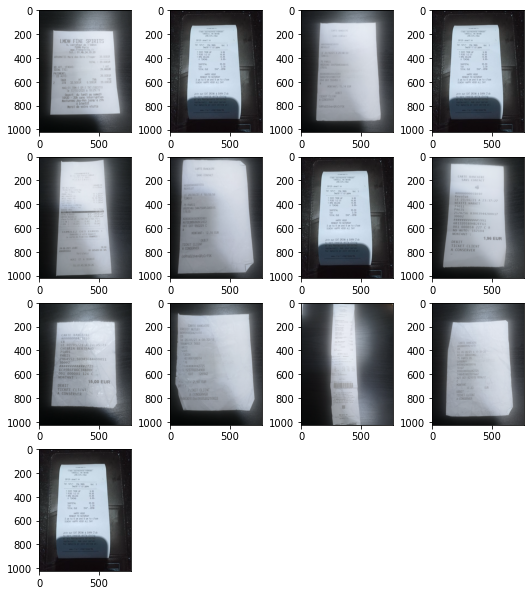

In [157]:
# Plot processed images
multi_img_plot(imgs)

# 4. Gcloud vision API request

Build an api request to send an image to the GCloud Vision API and recieve image text and ROI (region of interest) annotations as a reponse. The JSON response will then be stored in a pandas dataframe ready to be pushed to S3 as a csv file. 

In [ ]:
#Modified code from Johann 

import io
import os
import math
import pandas as pd
import cv2

# Imports the Google Cloud client library
from google.cloud import vision


# Environment variable must be set before the function can be used
# Terminal command : export GOOGLE_APPLICATION_CREDENTIALS=path_to_gcloud_credientials

def generate_annotations(input_img):
    """Procedure: Generate a csv file with the output of googlevision API text detection
    -------
    Input:
    -------
    input_img: opencv image 
    -------
    Output: 
    -------
    input_img: opencv image
    
    result df: Pandas dataframe object containing annotations from gcloud vision api
        index : index of the box
        text : string
            the text of the given box
        box_center_x : float
            the x coordinate of the center of the given box
        box_center_y : float
            the y coordinate of the center of the given box
        box_width : int
            the width of the given box
        box_height : int
            the height of the given box
    """
    # Instantiates a client
    client = vision.ImageAnnotatorClient()
    img_str = cv2.imencode('.jpg', input_img)[1].tostring()
    img = vision.Image(content=img_str)

    # Performs text detection on the image file
    response = client.text_detection(image=img)

    # Initialize a Dictionnary to store the results
    result = {'text': [], 'box_center_x': [], 'box_center_y': [], 'box_width': [], 'box_height': []}

    # loop over the boxes
    for box in response.text_annotations:
        # Text content of the box
        text_content = box.description

        # Initialize the minimum and maximum coordinates of the box
        min_x = math.inf
        max_x = 0
        min_y = math.inf
        max_y = 0

        # Loop over the corners of the box to get the minimum and maximum coordinates of
        # the corners of the box
        for corner in box.bounding_poly.vertices:
            if corner.x < min_x:
                min_x = corner.x
            if corner.x > max_x:
                max_x = corner.x
            if corner.y < min_y:
                min_y = corner.y
            if corner.y > max_y:
                max_y = corner.y

        # Calculate the center, width and height of the box
        box_width = max_x - min_x
        box_height = max_y - min_y
        box_center_x = min_x + (box_width / 2)
        box_center_y = min_y + (box_height / 2)

        # Store the results in the Dictionnary
        result['text'].append(text_content)
        result['box_center_x'].append(box_center_x)
        result['box_center_y'].append(box_center_y)
        result['box_width'].append(box_width)
        result['box_height'].append(box_height)

    # Store results in a pandas dataframe 
    result_df = pd.DataFrame(result)
    return input_img, result_df


In [ ]:
img, df = generate_annotations(imgs[0])

# 5. Main program function 

The main program function will execute all of the functions in this notebook for a small number of images ~10 to begin with to test functionallity. 

In [ ]:
def main(bucket, key):
    """Procedure:
    -------
    Input
    -------

    -------
    Output
    -------

    """
    # Get paths from S3 bucket and load images into list of numpy arrays
    s3_img_uris = get_s3_image_uris(bucket, key)
    
    for i, path in enumerate(s3_img_uris)
        # Read image from s3
        img = s3_image_read(bucket, path)
        
        # Image processing 
        # Check for text orientation and rotate image accordingly
        rotated_img = rotate_image(img)
        # Resize image
        processed_img = image_resize(rotated_img)
        
        # Write image to database
        db_write(processed_img)
    
    return 0

# (iii) Image rotate function testing

90


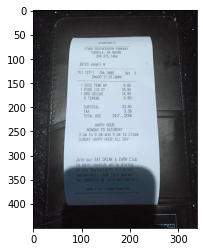

In [77]:
# Image rotation function testing

plt.imshow(rotate_image(img))

270


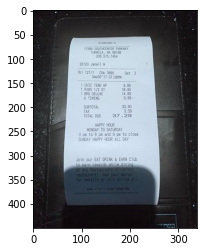

In [83]:
plt.imshow(rotate_image(img_90_counterclockwise))

0


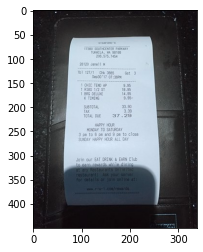

In [79]:
plt.imshow(rotate_image(img_90_clockwise))

In [ ]:
plt.imshow(rotate_image(img_180))

In [ ]:
img_paths = os.listdir(os.path.abspath('data'))

In [ ]:
def multi_img_plot(imgs): 
    fig = plt.figure(figsize=(9, 13))
    columns = 4
    rows = 5
    for i in range(1,len(imgs)):
        fig.add_subplot(rows, columns, i)
        plt.imshow(imgs[i])
    plt.show()
    
def get_img_paths_local():
    paths = os.listdir(os.path.abspath('data'))
    img_paths = []
    for i, path in enumerate(paths):
        if path.endswith('.jpg'):
            img_paths.append(path)
    return img_paths

def img_processing_test(img_paths): 
    processed_imgs = []
    
    for i, path in enumerate(img_paths):
        im_path = os.path.abspath('data/' + path)
        img = cv2.imread(im_path)
        rotated_img = rotate_image(img)
        resized_img = image_resize(rotated_img)
        processed_imgs.append(resized_img)

    return processed_imgs

In [ ]:
img_paths = get_img_paths_local()
imgs = img_processing_test(img_paths)

In [ ]:
multi_img_plot(imgs)

In [ ]:
cv2.imwrite('test_img.jpg', imgs[11])

# 4. Gcloud vision API request

Build an api request to send an image to the GCloud Vision API and recieve image text and ROI (region of interest) annotations as a reponse. The JSON response will then be stored in a pandas dataframe ready to be pushed to S3 as a csv file. 

In [ ]:
#Modified code from Johann 

import io
import os
import math
import pandas as pd
import cv2

# Imports the Google Cloud client library
from google.cloud import vision


# Environment variable must be set before the function can be used
# Terminal command : export GOOGLE_APPLICATION_CREDENTIALS=path_to_gcloud_credientials

def generate_annotations(input_img):
    """Procedure: Generate a csv file with the output of googlevision API text detection
    -------
    Input:
    -------
    input_img: opencv image 
    -------
    Output: 
    -------
    input_img: opencv image
    
    result df: Pandas dataframe object containing annotations from gcloud vision api
        index : index of the box
        text : string
            the text of the given box
        box_center_x : float
            the x coordinate of the center of the given box
        box_center_y : float
            the y coordinate of the center of the given box
        box_width : int
            the width of the given box
        box_height : int
            the height of the given box
    """
    # Instantiates a client
    client = vision.ImageAnnotatorClient()
    img_str = cv2.imencode('.jpg', input_img)[1].tostring()
    img = vision.Image(content=img_str)

    # Performs text detection on the image file
    response = client.text_detection(image=img)

    # Initialize a Dictionnary to store the results
    result = {'text': [], 'box_center_x': [], 'box_center_y': [], 'box_width': [], 'box_height': []}

    # loop over the boxes
    for box in response.text_annotations:
        # Text content of the box
        text_content = box.description

        # Initialize the minimum and maximum coordinates of the box
        min_x = math.inf
        max_x = 0
        min_y = math.inf
        max_y = 0

        # Loop over the corners of the box to get the minimum and maximum coordinates of
        # the corners of the box
        for corner in box.bounding_poly.vertices:
            if corner.x < min_x:
                min_x = corner.x
            if corner.x > max_x:
                max_x = corner.x
            if corner.y < min_y:
                min_y = corner.y
            if corner.y > max_y:
                max_y = corner.y

        # Calculate the center, width and height of the box
        box_width = max_x - min_x
        box_height = max_y - min_y
        box_center_x = min_x + (box_width / 2)
        box_center_y = min_y + (box_height / 2)

        # Store the results in the Dictionnary
        result['text'].append(text_content)
        result['box_center_x'].append(box_center_x)
        result['box_center_y'].append(box_center_y)
        result['box_width'].append(box_width)
        result['box_height'].append(box_height)

    # Store results in a pandas dataframe 
    result_df = pd.DataFrame(result)
    return input_img, result_df


# 5. Main program function 

The main program function will execute all of the functions in this notebook for a small number of images ~10 to begin with to test functionallity. 

In [ ]:
def main(bucket, key):
    """Procedure:
    -------
    Input
    -------

    -------
    Output
    -------

    """
    # Get paths from S3 bucket and load images into list of numpy arrays
    s3_img_uris = get_s3_image_uris(bucket, key)
    
    for i, path in enumerate(s3_img_uris)
        # Read image from s3
        img = s3_image_read(bucket, path)
        
        # Image processing 
        # Check for text orientation and rotate image accordingly
        rotated_img = rotate_image(img)
        # Resize image
        processed_img = image_resize(rotated_img)
        
        # Write image to database
        db_write(processed_img)
    
    return 0

180


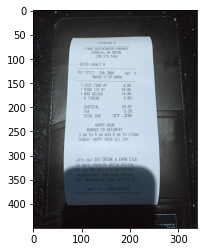

In [84]:
def main(bucket, key):
    """Procedure:
    -------
    Input
    -------

    -------
    Output
    -------

    """
    # Get paths from S3 bucket and load images into list of numpy arrays
    s3_img_uris = get_s3_image_uris(bucket, key)
    
    for i, path in enumerate(s3_img_uris)
        # Read image from s3
        img = s3_image_read(bucket, path)
        
        # Image processing 
        # Check for text orientation and rotate image accordingly
        rotated_img = rotate_image(img)
        # Resize image
        processed_img = image_resize(rotated_img)
        
        # Write image to database
        db_write(processed_img)
    
    return 0

In [92]:
img_paths = os.listdir(os.path.abspath('data'))

In [141]:
def multi_img_plot(imgs): 
    fig = plt.figure(figsize=(9, 13))
    columns = 4
    rows = 5
    for i in range(1,len(imgs)):
        fig.add_subplot(rows, columns, i)
        plt.imshow(imgs[i])
    plt.show()
    
def get_img_paths_local():
    paths = os.listdir(os.path.abspath('data'))
    img_paths = []
    for i, path in enumerate(paths):
        if path.endswith('.jpg'):
            img_paths.append(path)
    return img_paths

def img_processing_test(img_paths): 
    processed_imgs = []
    
    for i, path in enumerate(img_paths):
        im_path = os.path.abspath('data/' + path)
        img = cv2.imread(im_path)
        rotated_img = rotate_image(img)
        resized_img = image_resize(rotated_img)
        processed_imgs.append(resized_img)

    return processed_imgs

In [143]:
img_paths = get_img_paths_local()
imgs = img_processing_test(img_paths)

90
(1024, 768, 3)
90
(1024, 768, 3)
0
(1022, 768, 3)
270
(1024, 768, 3)
90
(1022, 768, 3)
0
(1024, 768, 3)
270
(1024, 768, 3)
180
(1022, 768, 3)
0
(1024, 768, 3)
0
(1024, 768, 3)
0
(1024, 768, 3)
270
(1024, 768, 3)
270
(1024, 768, 3)
270
(1022, 768, 3)


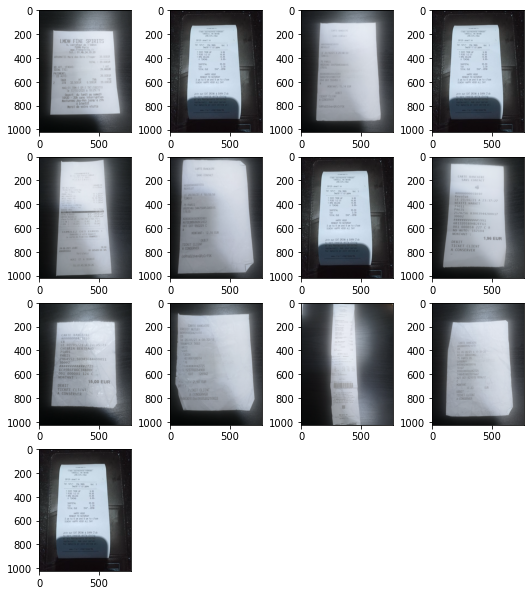

In [144]:
multi_img_plot(imgs)

In [154]:
cv2.imwrite('test_img.jpg', imgs[11])

True

# 4. Gcloud vision API request

Build an api request to send an image to the GCloud Vision API and recieve image text and ROI (region of interest) annotations as a reponse. The JSON response will then be stored in a pandas dataframe ready to be pushed to S3 as a csv file. 

In [147]:
#Modified code from Johann 

import io
import os
import math
import pandas as pd
import cv2

# Imports the Google Cloud client library
from google.cloud import vision


# Environment variable must be set before the function can be used
# Terminal command : export GOOGLE_APPLICATION_CREDENTIALS=path_to_gcloud_credientials

def generate_annotations(input_img):
    """Procedure: Generate a csv file with the output of googlevision API text detection
    -------
    Input:
    -------
    input_img: opencv image 
    -------
    Output: 
    -------
    input_img: opencv image
    
    result df: Pandas dataframe object containing annotations from gcloud vision api
        index : index of the box
        text : string
            the text of the given box
        box_center_x : float
            the x coordinate of the center of the given box
        box_center_y : float
            the y coordinate of the center of the given box
        box_width : int
            the width of the given box
        box_height : int
            the height of the given box
    """
    # Instantiates a client
    client = vision.ImageAnnotatorClient()
    img_str = cv2.imencode('.jpg', input_img)[1].tostring()
    img = vision.Image(content=img_str)

    # Performs text detection on the image file
    response = client.text_detection(image=img)

    # Initialize a Dictionnary to store the results
    result = {'text': [], 'box_center_x': [], 'box_center_y': [], 'box_width': [], 'box_height': []}

    # loop over the boxes
    for box in response.text_annotations:
        # Text content of the box
        text_content = box.description

        # Initialize the minimum and maximum coordinates of the box
        min_x = math.inf
        max_x = 0
        min_y = math.inf
        max_y = 0

        # Loop over the corners of the box to get the minimum and maximum coordinates of
        # the corners of the box
        for corner in box.bounding_poly.vertices:
            if corner.x < min_x:
                min_x = corner.x
            if corner.x > max_x:
                max_x = corner.x
            if corner.y < min_y:
                min_y = corner.y
            if corner.y > max_y:
                max_y = corner.y

        # Calculate the center, width and height of the box
        box_width = max_x - min_x
        box_height = max_y - min_y
        box_center_x = min_x + (box_width / 2)
        box_center_y = min_y + (box_height / 2)

        # Store the results in the Dictionnary
        result['text'].append(text_content)
        result['box_center_x'].append(box_center_x)
        result['box_center_y'].append(box_center_y)
        result['box_width'].append(box_width)
        result['box_height'].append(box_height)

    # Store results in a pandas dataframe 
    result_df = pd.DataFrame(result)
    return input_img, result_df


# 5. Main program function 

The main program function will execute all of the functions in this notebook for a small number of images ~10 to begin with to test functionallity. 

In [ ]:
def main(bucket, key):
    """Procedure:
    -------
    Input
    -------

    -------
    Output
    -------

    """
    # Get paths from S3 bucket and load images into list of numpy arrays
    s3_img_uris = get_s3_image_uris(bucket, key)
    
    for i, path in enumerate(s3_img_uris)
        # Read image from s3
        img = s3_image_read(bucket, path)
        
        # Image processing 
        # Check for text orientation and rotate image accordingly
        rotated_img = rotate_image(img)
        # Resize image
        processed_img = image_resize(rotated_img)
        
        # Write image to database
        db_write(processed_img)
    
    return 0